In [31]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer

In [32]:
df=pd.read_excel('dataset_filledsupplier_currency_orderday.xlsx')

In [33]:
currency=pd.read_excel('currency_data.xlsx')

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24621 entries, 0 to 24620
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   청구서번호        24621 non-null  object 
 1   No.          24621 non-null  int64  
 2   Subject      24599 non-null  object 
 3   Machinery    24621 non-null  object 
 4   Assembly     24621 non-null  object 
 5   청구품목         24621 non-null  object 
 6   Unnamed: 6   0 non-null      float64
 7   Part No.1    24602 non-null  object 
 8   Part No.2    3592 non-null   object 
 9   청구량          24517 non-null  float64
 10  견적           24171 non-null  object 
 11  견적수량         24517 non-null  float64
 12  견적화폐         24621 non-null  object 
 13  견적단가         24621 non-null  float64
 14  발주번호         24621 non-null  object 
 15  발주처          24621 non-null  object 
 16  발주           24621 non-null  object 
 17  발주수량         24621 non-null  int64  
 18  발주금액         24621 non-null  float64
 19  D/T 

## 클리닝

In [35]:
missing_conditions = df[
    df['발주'].notnull() &  # 발주 일자는 비어있지 않음
    df['미입고 기간'].isnull() &  # 미입고 기간은 비어있음
    df['창고입고'].isnull() & # 창고 입고도 비어있음
    df['선박입고'].isnull()  # 선박 입고도 비어있음

]

print(f"발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: {len(missing_conditions)}개")
df = df.drop(missing_conditions.index)

print(f"삭제된 행의 개수: {len(missing_conditions)}개")
print(f"남은 데이터프레임의 크기: {df.shape}")

발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: 1699개
삭제된 행의 개수: 1699개
남은 데이터프레임의 크기: (22922, 32)


In [36]:
#미입고기간으로 처리.
missing_both = df[df['창고입고'].isnull() & df['미입고 기간'].notnull()]

print(f"창고 입고일은 없고 미입고 기간은 명시되어 있어 미입고 기간으로 분류해야 할 경우 : {len(missing_both)}개")

창고 입고일은 없고 미입고 기간은 명시되어 있어 미입고 기간으로 분류해야 할 경우 : 1620개


In [37]:
df = df[df['미입고 기간'].isnull()]
df = df.dropna(subset=['창고입고'])

In [38]:
df['창고입고'] = pd.to_datetime(df['창고입고'], errors='coerce')
currency['기간'] = pd.to_datetime(currency['기간'], errors='coerce')
df['발주'] = pd.to_datetime(df['발주'], errors='coerce')

### 기존 리드타임 1< leadtime < 200

In [39]:
df['리드타임'] = (df['창고입고'] - df['발주']).dt.days
df['리드타임'] = df['리드타임'].apply(lambda x: 1 if x == 0 else x)

df = df[(df['리드타임'] > 1 ) & (df['리드타임'] < 150)]
df = df.dropna(subset=['창고입고'])

In [40]:
df = pd.merge_asof(df.sort_values('창고입고'), 
                   currency.sort_values('기간'), 
                   left_on='창고입고', 
                   right_on='기간', 
                   direction='backward')

In [41]:
def get_exchange_rate(row):
    if row['견적화폐'] == 'USD':
        return row['USD']
    elif row['견적화폐'] == 'JPY':
        return row['JPY']
    elif row['견적화폐'] == 'EUR':
        return row['EUR']
    else:
        return 1 

df['환율'] = df.apply(get_exchange_rate, axis=1)

print(df['환율'].isnull().sum())  #이거 미국장 연말 쉬는거 나옴 

df['환율'].fillna(method='ffill', inplace=True)  


3


C:\Users\User\AppData\Local\Temp\ipykernel_9736\3418987294.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['환율'].fillna(method='ffill', inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_9736\3418987294.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['환율'].fillna(method='ffill', inplace=True)


### 날짜뽑기

> 연도는 숫자형으로 처리(새로운 연도에 대응)
> 나머지는 원핫인코딩

In [42]:
# 월(month), 요일(day of the week) 추출
df['month'] = df['창고입고'].dt.month
df['day_of_week'] = df['창고입고'].dt.dayofweek
df['year'] = df['창고입고'].dt.year

def get_season(date):
    month = date.month
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:
        return '겨울'

df['season'] = df['창고입고'].apply(get_season)

df = pd.get_dummies(df, columns=['month', 'day_of_week', 'season'], drop_first=True)


In [45]:
print(df.columns)

Index(['청구서번호', 'No.', 'Subject', 'Machinery', 'Assembly', '청구품목',
       'Unnamed: 6', 'Part No.1', 'Part No.2', '청구량', '견적', '견적수량', '견적화폐',
       '견적단가', '발주번호', '발주처', '발주', '발주수량', '발주금액', 'D/T', '미입고 기간', '창고입고',
       '창고입고수량', 'Control No.', '입고창고', '창고출고', '창고출고수량', '출고선박', '출고운반선',
       '선박입고', '선박입고수량', '완료 여부', '리드타임', '기간', 'USD', 'JPY', 'EUR', '환율',
       'year', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6', 'season_겨울', 'season_봄', 'season_여름'],
      dtype='object')


In [13]:
df['year_exchange_rate'] = df['year'] * df['환율']

# 7. 팬데믹 여부 플래그 추가
def pandemic_flag(year):
    if year in [2020, 2021]:
        return 1
    else:
        return 0

df['pandemic_flag'] = df['year'].apply(pandemic_flag)

In [14]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'[^\w\s\*/\-\+.,#&]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\b(사용금지|사)\b', '', text, flags=re.IGNORECASE)
    text = text.strip()
    return text

def clean_supplier_name(name):
    name = name.lower()
    name = re.sub(r'coporation|coropration|coproration|corporration', 'corporation', name)
    name = re.sub(r'\(사용금지\)', '', name)
    name = re.sub(r'u\.s\.a', '_usa', name)
    name = re.sub(r'\.', '', name)
    suffixes = r'(corporation|corp|company|co|incorporated|inc|limited|ltd|상사|공사|엔지니어링|주식회사|주|gmbh|pte ltd|llc)'
    name = re.sub(suffixes, '', name, flags=re.IGNORECASE)
    name = re.sub(r'[^\w\s-]', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name



In [15]:

text_columns = ['Machinery', 'Assembly', '청구품목']

for col in text_columns:
    df[col] = df[col].astype(str)
df['cleaned_machinery'] = df['Machinery'].apply(preprocess_text)
df['cleaned_assembly'] = df['Assembly'].apply(preprocess_text)
df['cleaned_item'] = df['청구품목'].apply(preprocess_text)
df['cleaned_supplier'] = df['발주처'].apply(clean_supplier_name)

> 단순 조합해서 평균낸게.. 악영향일까

In [16]:
# Machinery별 평균 리드타임 계산
machinery_avg_leadtime = df.groupby('cleaned_machinery')['리드타임'].mean().reset_index()
machinery_avg_leadtime.rename(columns={'리드타임': 'machinery_avg_leadtime'}, inplace=True)

# 데이터프레임에 평균 리드타임 추가
df = df.merge(machinery_avg_leadtime, on='cleaned_machinery', how='left')

In [17]:
# Machinery & Assembly & supplier 조합별 평균 리드타임 계산
df['machinery_assembly_supplier'] = df['cleaned_machinery'] + " & " + df['cleaned_assembly'] + " & " + df['cleaned_supplier']
machinery_assembly_supplier_avg_leadtime = df.groupby('machinery_assembly_supplier')['리드타임'].mean().reset_index()
machinery_assembly_supplier_avg_leadtime.rename(columns={'리드타임': 'machinery_assembly_supplier_avg_leadtime'}, inplace=True)

df = df.merge(machinery_assembly_supplier_avg_leadtime, on='machinery_assembly_supplier', how='left')

In [18]:
# Machinery & Assembly 조합별 평균 리드타임 계산
df['machinery_assembly'] = df['cleaned_machinery'] + " & " + df['cleaned_assembly']
assembly_machinery_avg_leadtime = df.groupby('machinery_assembly')['리드타임'].mean().reset_index()
assembly_machinery_avg_leadtime.rename(columns={'리드타임': 'machinery_assembly_avg_leadtime'}, inplace=True)

# 데이터프레임에 Machinery & Assembly 조합의 평균 리드타임 추가
df = df.merge(assembly_machinery_avg_leadtime, on='machinery_assembly', how='left')


In [19]:
# Assembly 평균 리드타임 계산
assembly_avg_leadtime = df.groupby('cleaned_assembly')['리드타임'].mean().reset_index()
assembly_avg_leadtime.rename(columns={'리드타임': 'assembly_avg_leadtime'}, inplace=True)

# 데이터프레임에 평균 리드타임 추가
df = df.merge(assembly_avg_leadtime, on='cleaned_assembly', how='left')

In [20]:
# 발주처별 평균 리드타임 계산 (cleaned_supplier 사용)
supplier_leadtime_avg = df.groupby('cleaned_supplier')['리드타임'].mean().reset_index()
supplier_leadtime_avg.rename(columns={'리드타임': 'supplier_avg_leadtime'}, inplace=True)

# 원본 데이터프레임에 발주처별 평균 리드타임 추가 (cleaned_supplier로 병합)
df = df.merge(supplier_leadtime_avg, on='cleaned_supplier', how='left')


In [21]:
# 발주처별 + Machinery 조합별 평균 리드타임 계산
supplier_machinery_leadtime = df.groupby(['cleaned_supplier', 'cleaned_machinery'])['리드타임'].mean().reset_index()
supplier_machinery_leadtime.rename(columns={'리드타임': 'supplier_machinery_avg_leadtime'}, inplace=True)

# 원본 데이터프레임에 병합
df = df.merge(supplier_machinery_leadtime, on=['cleaned_supplier', 'cleaned_machinery'], how='left')

In [22]:
df[['Machinery','Assembly','리드타임', '발주처', 'assembly_avg_leadtime', 'machinery_avg_leadtime', 'machinery_assembly_supplier_avg_leadtime','machinery_assembly_avg_leadtime', 'supplier_machinery_avg_leadtime']].tail(20)

,Machinery,Assembly,리드타임,발주처,assembly_avg_leadtime,machinery_avg_leadtime,machinery_assembly_supplier_avg_leadtime,machinery_assembly_avg_leadtime,supplier_machinery_avg_leadtime
17500,NO.1 MAIN AIR COMPRESSOR,CYLINDER & HEAD GROUP,61,MATSUI(U.S.A) COROPRATION,64.307692,44.666667,61.833333,64.307692,63.150943
17501,NO.1 MAIN AIR COMPRESSOR,GASKET KIT,61,MATSUI(U.S.A) COROPRATION,62.287671,44.666667,61.000000,61.000000,63.150943
17502,PURSE WINCH,BRAKE,61,MATSUI(U.S.A) COROPRATION,79.564103,86.409409,54.777778,79.564103,63.035714
17503,No.1 X-BAND RADAR,XN4A ANTENNA UNIT,42,FURUNO,36.115385,26.739130,26.666667,35.944444,24.361111
17504,No.1 X-BAND RADAR,XN4A ANTENNA UNIT,42,FURUNO,36.115385,26.739130,26.666667,35.944444,24.361111
17505,CORKLINE STACKER,DRAGGING SHEAVE MECHANISM,22,K.TH MARCO,95.604167,91.956522,96.531915,95.604167,92.544118
17506,LUB. OIL,SHELL OIL,6,한국쉘석유㈜,15.018868,15.643411,14.978947,15.018868,14.943925
17507,MAIN ENGINE,AIR FILTER WITH SILENCER INSTALLATION,88,"yusinHR Co., Ltd.",85.166667,80.628627,78.400000,85.166667,81.116667
17508,MAIN ENGINE,"CRANKSHAFT, FLYWHEEL AND VIBRATION DAMPER",88,"yusinHR Co., Ltd.",88.000000,80.628627,88.000000,88.000000,81.116667
17509,MAIN ENGINE,"CRANKSHAFT, FLYWHEEL AND VIBRATION DAMPER",88,"yusinHR Co., Ltd.",88.000000,80.628627,88.000000,88.000000,81.116667


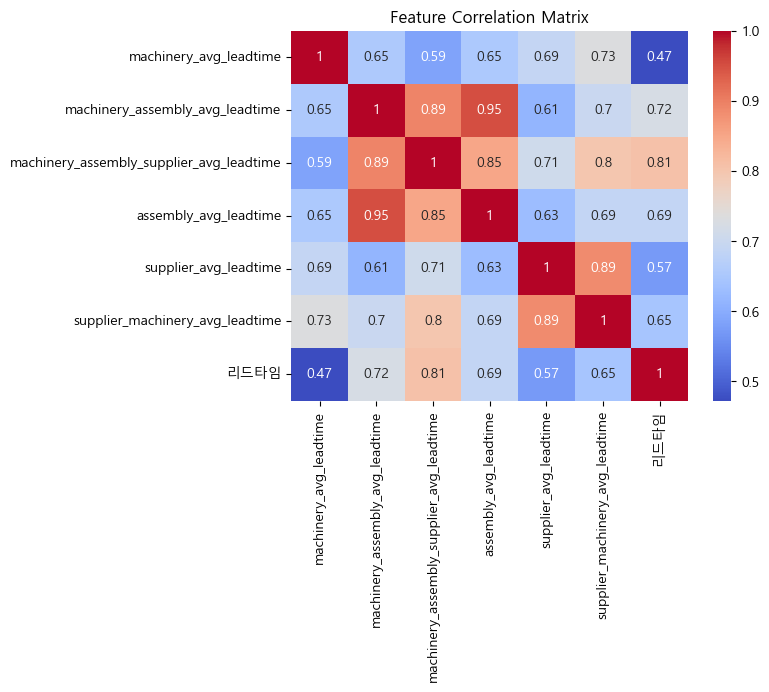

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# 피처 간 상관관계 계산 및 시각화
correlation_matrix = df[['machinery_avg_leadtime', 'machinery_assembly_avg_leadtime', 'machinery_assembly_supplier_avg_leadtime', 'assembly_avg_leadtime',
                         'supplier_avg_leadtime', 'supplier_machinery_avg_leadtime', '리드타임']].corr()
plt.rcParams['font.family']='Malgun Gothic'

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

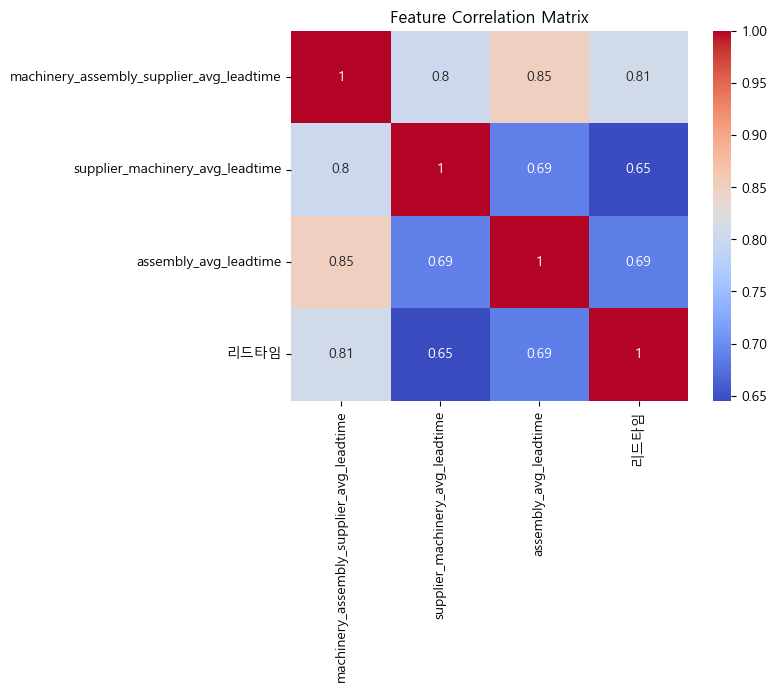

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# 살리고 싶은 피쳐
correlation_matrix = df[['machinery_assembly_supplier_avg_leadtime','supplier_machinery_avg_leadtime', 'assembly_avg_leadtime', '리드타임']].corr()
plt.rcParams['font.family']='Malgun Gothic'

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

### 리드타임 예측 (회귀)
1. 텍스트 칼럼 결합 word2vec
2. 수치형 데이터 Scaling
3. 범주형 데이터(견적화폐) onehotEncoding
4. 모델의 입력, 2.3데이터 결합 => 리드타임 예측

In [26]:
from scipy.stats import boxcox

X = df.drop(columns=['리드타임'])
y = df['리드타임'].values


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.15, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [27]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import numpy as np

numerical_features = ['machinery_assembly_supplier_avg_leadtime','supplier_machinery_avg_leadtime', 'machinery_avg_leadtime','year_exchange_rate']

scaler = MinMaxScaler()
X_train_numerical = scaler.fit_transform(X_train[numerical_features])
X_val_numerical = scaler.transform(X_val[numerical_features])
X_test_numerical = scaler.transform(X_test[numerical_features])



In [28]:
import pickle

# 'MinMaxScaler.pkl' 파일로 저장
with open('MinMaxScaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [49]:

# 가중치 부여: 두 번째 칼럼인 'machinery_assembly_avg_leadtime'에 2배 가중치 적용
#X_train_numerical[:, 1] *= 2
#X_val_numerical[:, 1] *= 2
#X_test_numerical[:, 1] *= 2

# 결과 확인
# print(f"X_train_numerical with weight applied: {X_train_numerical[:5]}")

In [29]:
currency_ohe = OneHotEncoder(sparse_output=False)
currency_train_encoded = currency_ohe.fit_transform(X_train[['견적화폐']])
currency_val_encoded = currency_ohe.transform(X_val[['견적화폐']])
currency_test_encoded = currency_ohe.transform(X_test[['견적화폐']])


In [30]:
import pickle

# 'MinMaxScaler.pkl' 파일로 저장
with open('OneHotEncoder.pkl', 'wb') as f:
    pickle.dump(currency_ohe, f)

In [51]:
from gensim.models import Word2Vec

machinery_sentences_train = [text.split() for text in X_train['cleaned_machinery']]
assembly_sentences_train = [text.split() for text in X_train['cleaned_assembly']]

machinery_sentences_val = [text.split() for text in X_val['cleaned_machinery']]
assembly_sentences_val  = [text.split() for text in X_val['cleaned_assembly']]

machinery_sentences_test = [text.split() for text in X_test['cleaned_machinery']]
assembly_sentences_test = [text.split() for text in X_test['cleaned_assembly']]

word2vec_machinery = Word2Vec(sentences=machinery_sentences_train, vector_size=100, window=5, min_count=1, workers=4)
word2vec_assembly = Word2Vec(sentences=assembly_sentences_train, vector_size=100, window=5, min_count=1, workers=4)

def sentence_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

machinery_vectors_train = np.array([sentence_vector(sentence.split(), word2vec_machinery) for sentence in X_train['cleaned_machinery']])
assembly_vectors_train = np.array([sentence_vector(sentence.split(), word2vec_assembly) for sentence in X_train['cleaned_assembly']])

machinery_vectors_val = np.array([sentence_vector(sentence.split(), word2vec_machinery) for sentence in X_val['cleaned_machinery']])
assembly_vectors_val = np.array([sentence_vector(sentence.split(), word2vec_assembly) for sentence in X_val['cleaned_assembly']])

machinery_vectors_test = np.array([sentence_vector(sentence.split(), word2vec_machinery) for sentence in X_test['cleaned_machinery']])
assembly_vectors_test = np.array([sentence_vector(sentence.split(), word2vec_assembly) for sentence in X_test['cleaned_assembly']])


In [52]:
supplier_sentences = [text.split() for text in df['cleaned_supplier']]

word2vec_supplier = Word2Vec(sentences=supplier_sentences, vector_size=100, window=5, min_count=1, workers=4)

supplier_vectors = np.array([sentence_vector(sentence, word2vec_supplier) for sentence in supplier_sentences])
print(f"Word2Vec Supplier Shape: {supplier_vectors.shape}")


Word2Vec Supplier Shape: (17520, 100)


In [53]:
#word2vec_supplier.save('word2vec_supplier.model')

In [54]:
#word2vec_machinery.save('word2vec_machinery.model')
#word2vec_assembly.save('word2vec_assembly.model')

In [55]:
# 각 데이터셋의 One-Hot Encoding 및 추가 피처 추출
X_train_month_features = X_train.filter(like='month_').values
X_train_day_of_week_features = X_train.filter(like='day_of_week_').values
X_train_season_features = X_train.filter(like='season_').values
pandemic_flag_train = X_train['pandemic_flag'].values.reshape(-1, 1)

X_val_month_features = X_val.filter(like='month_').values
X_val_day_of_week_features = X_val.filter(like='day_of_week_').values
X_val_season_features = X_val.filter(like='season_').values
pandemic_flag_val = X_val['pandemic_flag'].values.reshape(-1, 1)

X_test_month_features = X_test.filter(like='month_').values
X_test_day_of_week_features = X_test.filter(like='day_of_week_').values
X_test_season_features = X_test.filter(like='season_').values
pandemic_flag_test = X_test['pandemic_flag'].values.reshape(-1, 1)


In [56]:
X_train_combined = np.hstack((
    X_train_numerical,           # 스케일링된 수치형 피처들
    X_train_month_features,      # 월 One-Hot-Encoding 피처
    X_train_day_of_week_features, # 요일 One-Hot-Encoding 피처
    X_train_season_features,     # 계절 One-Hot-Encoding 피처
    currency_train_encoded,      # 견적화폐 One-Hot-Encoding 피처
    pandemic_flag_train,         # 팬데믹 플래그
    machinery_vectors_train,     # Word2Vec 벡터화된 machinery 피처
    assembly_vectors_train       # Word2Vec 벡터화된 assembly 피처
))

# 검증 데이터 결합
X_val_combined = np.hstack((
    X_val_numerical,
    X_val_month_features,
    X_val_day_of_week_features,
    X_val_season_features,
    currency_val_encoded,
    pandemic_flag_val,
    machinery_vectors_val,
    assembly_vectors_val
))

# 테스트 데이터 결합
X_test_combined = np.hstack((
    X_test_numerical,
    X_test_month_features,
    X_test_day_of_week_features,
    X_test_season_features,
    currency_test_encoded,
    pandemic_flag_test,
    machinery_vectors_test,
    assembly_vectors_test
))

In [57]:
print(X_val_combined.shape)

(1314, 229)


In [58]:
#import pickle

#with open('MinMaxScaler.pkl', 'wb') as f:
#    pickle.dump(scaler, f)

### 데이터 분할


In [59]:
print(f"X_train shape: {X_train_combined.shape}")
print(f"X_train shape: {X_val_combined.shape}")
print(f"X_test shape: {X_test_combined.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (14892, 229)
X_train shape: (1314, 229)
X_test shape: (1314, 229)
y_train shape: (14892,)
y_test shape: (1314,)
y_test shape: (1314,)


In [60]:
import lightgbm as lgb
from lightgbm import callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


model_lgb = lgb.LGBMRegressor(
    objective='regression',
    metric='mae', 
    learning_rate=0.05,  
    num_leaves=30, 
    max_depth=8,  
    n_estimators=5000,  
    subsample=0.8,  
    colsample_bytree=0.7,  
    reg_alpha=0.1, 
    reg_lambda=0.1 
)

# 콜백 설정
callbacks = [
    callback.early_stopping(stopping_rounds=50),  
    callback.log_evaluation(period=1000)  
]

# 모델 학습
model_lgb.fit(
    X_train_combined, y_train,
    eval_set=[(X_val_combined, y_val)],  
    eval_metric='mae',
    callbacks=callbacks
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37885
[LightGBM] [Info] Number of data points in the train set: 14892, number of used features: 229
[LightGBM] [Info] Start training from score 58.890142
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.05, max_depth=8,
              metric='mae', n_estimators=5000, num_leaves=30,
              objective='regression', reg_alpha=0.1, reg_lambda=0.1,
              subsample=0.8)

In [61]:
y_pred = model_lgb.predict(X_test_combined)
y_pred = np.maximum(0, y_pred)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")

Mean Absolute Error (MAE): 3.5253656101645
Root Mean Squared Error (RMSE): 10.090693190902583
Mean Squared Error (MSE): 101.82208907292775
R^2 Score: 0.9445048657335116


### 앞버전 성능(1<leadtime<200, 환율피쳐, 팬데믹피쳐, m_a_s 다합친 평균피쳐 안넣은거)

> Mean Absolute Error (MAE): 5.402290372823216

> Root Mean Squared Error (RMSE): 15.153656625990125
 
> Mean Squared Error (MSE): 229.63330913841443
 
> R^2 Score: 0.9153701844128428

C:\Users\User\anaconda3\envs\ship\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


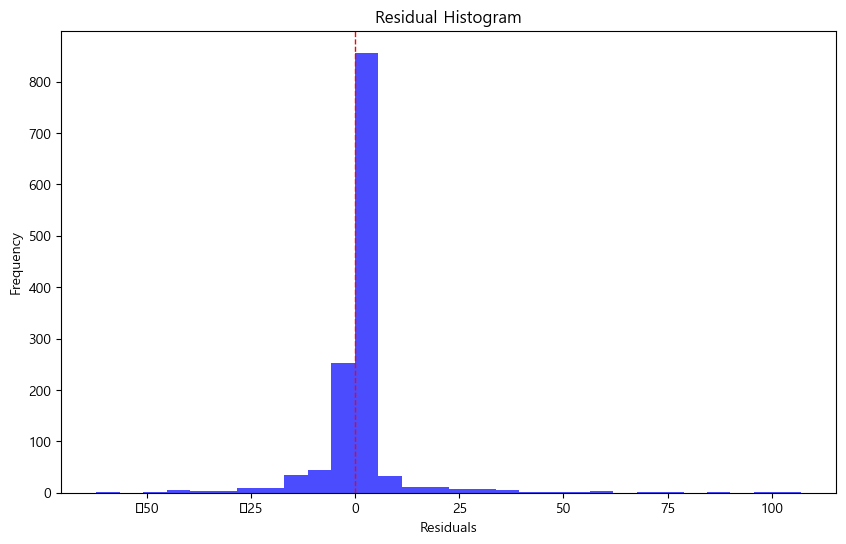

In [42]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Histogram')
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)  
plt.show()

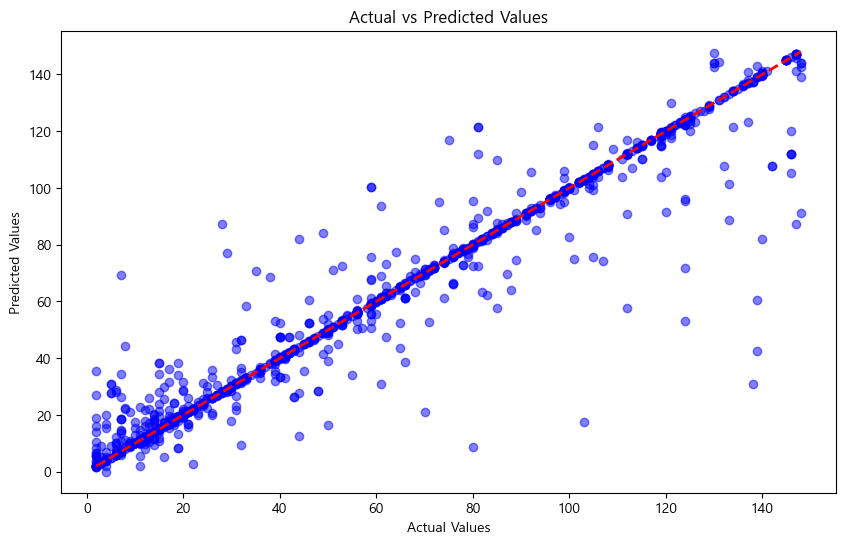

In [43]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # y=x 선
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

In [44]:

threshold = 50
residuals = y_test - y_pred
outliers = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Residual': residuals})
large_residuals = outliers[abs(outliers['Residual']) > threshold ] 
print(large_residuals)

      Actual  Predicted    Residual
95        80   8.659923   71.340077
257      138  30.962050  107.037950
291      140  82.149826   57.850174
451      139  42.713475   96.286525
627        7  69.200044  -62.200044
642       28  87.308972  -59.308972
892      148  91.210893   56.789107
1058     124  53.194196   70.805804
1075     147  87.359306   59.640694
1078     112  57.618607   54.381393
1291     103  17.611207   85.388793
1295     124  71.935008   52.064992
1308     139  60.370187   78.629813


In [46]:
y_test_df = pd.DataFrame(y_test, columns=['리드타임'])

residuals = y_test_df.values.flatten() - y_pred  # 실제값 - 예측값
large_residuals = np.abs(residuals)  # 절대값으로 잔차 크기 계산
large_residuals_indices = np.where(large_residuals > threshold)[0]  # 특정 임계값보다 큰 잔차의 인덱스 추출
large_residuals_data = X_test.iloc[large_residuals_indices]
large_residuals_actual = y_test_df.iloc[large_residuals_indices]
large_residuals_predicted = y_pred[large_residuals_indices]

large_residuals_df = pd.DataFrame({
    'Actual': large_residuals_actual.values.flatten(),  
    'Predicted': large_residuals_predicted,
    'Residual': residuals[large_residuals_indices],
    'machinery_avg_leadtime': large_residuals_data['machinery_avg_leadtime'].values,
    'machinery_assembly_avg_leadtime': large_residuals_data['machinery_assembly_avg_leadtime'].values,
    'supplier_machinery_avg_leadtime': large_residuals_data['supplier_machinery_avg_leadtime'].values,
    'machinery_assembly_supplier_avg_leadtime': large_residuals_data['machinery_assembly_supplier_avg_leadtime'].values,
    'machinery' : large_residuals_data['Machinery'].values,
    'assembly' : large_residuals_data['Assembly'].values,
    'supplier' : large_residuals_data['발주처'].values
})

print(large_residuals_df.head(10))

   Actual  Predicted    Residual  machinery_avg_leadtime  \
0      80   8.659923   71.340077               26.739130   
1     138  30.962050  107.037950               22.830189   
2     140  82.149826   57.850174               92.500000   
3     139  42.713475   96.286525               56.875088   
4       7  69.200044  -62.200044               56.875088   
5      28  87.308972  -59.308972               86.409409   
6     148  91.210893   56.789107               91.956522   
7     124  53.194196   70.805804               75.978510   
8     147  87.359306   59.640694               80.628627   
9     112  57.618607   54.381393               75.978510   

   machinery_assembly_avg_leadtime  supplier_machinery_avg_leadtime  \
0                        16.153846                        24.361111   
1                        21.542773                        22.198543   
2                        92.500000                        92.500000   
3                        39.533333                     